Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Import libs
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x
import tensorflow as tf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from math import nan
import random
import json
from future.utils import iteritems
import pickle
from requests import get

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode

!pip install transformers

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=6bd8873022e47eb9fd73f044a77215c657be86c98178f52275dcf8dfc24393c7
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 34.0 MB/s 


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['O', 'B-LEGISLACAO', 'I-LEGISLACAO']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['O', 'B-LEGISLACAO', 'I-LEGISLACAO']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['O', 'B-LEGISLACAO', 'I-LEGISLACAO']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

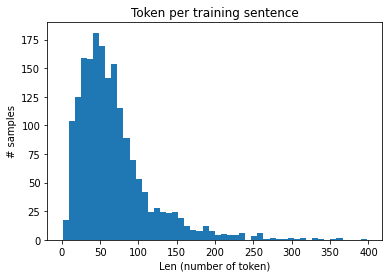

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

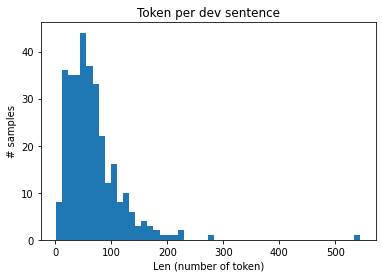

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

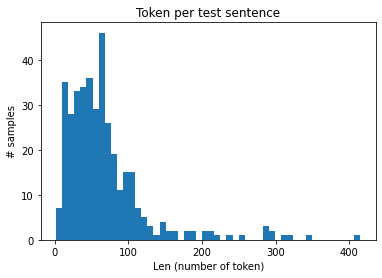

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i + 1 for i, w in enumerate(words)}
word2idx["PAD"] = 0 # Padding

idx2word = {i: w for w, i in iteritems(word2idx)}

tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

4841
919777
1
O


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9174)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 150
Points in y_train before removal: 150


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[12419, 3102, 8738, 4937, 802, 2414, 2699, 7409, 5417, 2699, 10524, 8738, 7393, 12419, 6459, 2062, 7633, 1521, 2966, 13166, 8772, 3086, 9053, 6997, 12028, 12841, 12407, 7393, 5371, 3102, 7393, 4414, 83, 2019, 777]
[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10975, 6252, 8738, 7875, 12407, 845, 12907, 7393, 11445, 12028, 6511, 12427, 3790, 1359, 105, 12028, 7453, 12028, 2328, 12870, 8738, 9045, 7080, 11878, 12055, 1673, 9053, 8118, 3658, 12028, 154, 9986, 4972, 157, 1185, 9155, 7797, 8142, 12028, 7795, 1552, 9053, 5701, 8738, 9053, 13113, 8738, 4865, 3102, 9053, 6269, 1983, 6596, 1495, 5716, 6561, 6920, 1583, 9448, 6080, 8738, 4829, 8738, 5716, 5676, 3945, 4273, 9448, 6888, 5716, 5676, 2740, 3102, 9448, 1800, 2699, 6156, 8300, 777]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=a342df743b56df1b42d4c05d9620735a1d9f32bead674002268cc58293783e87
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.2 MB/s 
     |████████████████████████████████| 163 kB 67.9 MB/s 
     |████████████████████████████████| 7.6 MB 23.9 MB/s 
[12419, 3102, 8738, 4937, 802, 2414, 2699, 7409, 5417, 2699,

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-16 05:39:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-16 05:39:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-16 05:40:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1903 words (11790 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 545, 100)          1369300   
                                                                 
 bidirectional (Bidirectiona  (None, 545, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 545, 3)           603       
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 545, 3)            9         
                                                                 
Total params: 1,530,712
Trainable params: 1,530,712
Non-trainable pa

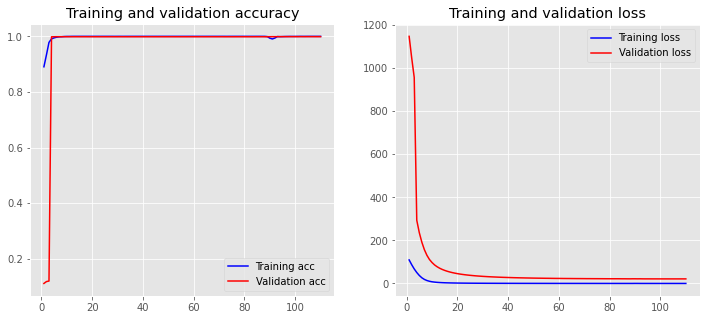

12/12 [==============================] - 5s 167ms/step
F1-score: 90.0%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9047231270358306,0.894524959742351,0.8995951417004049,1242.0
micro avg,0.9047231270358306,0.894524959742351,0.8995951417004049,1242.0
macro avg,0.9047231270358306,0.894524959742351,0.8995951417004049,1242.0
weighted avg,0.9047231270358306,0.894524959742351,0.8995951417004049,1242.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1888 words (11797 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 545, 100)          1368500   
                                                                 
 bidirectional_1 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,529,912
Trainable params: 1,529,912
Non-trainable 

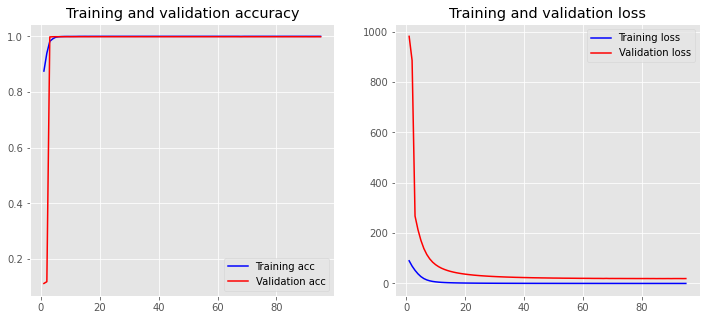

12/12 [==============================] - 5s 169ms/step
F1-score: 89.7%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.900974025974026,0.893719806763285,0.8973322554567501,1242.0
micro avg,0.900974025974026,0.893719806763285,0.8973322554567501,1242.0
macro avg,0.900974025974026,0.893719806763285,0.8973322554567501,1242.0
weighted avg,0.900974025974026,0.893719806763285,0.8973322554567502,1242.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1903 words (11788 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 545, 100)          1369100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,530,512
Trainable params: 1,530,512
Non-trainable 

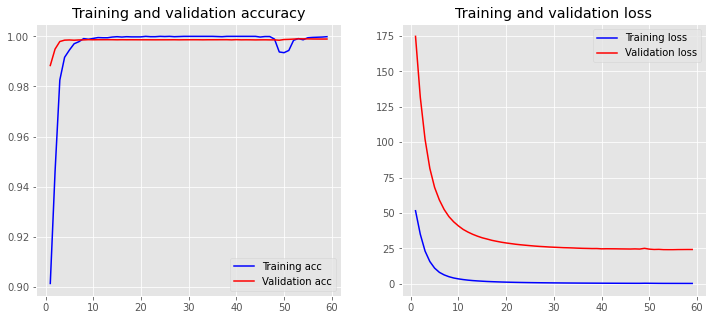

12/12 [==============================] - 5s 171ms/step
F1-score: 89.9%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9060457516339869,0.892914653784219,0.8994322789943228,1242.0
micro avg,0.9060457516339869,0.892914653784219,0.8994322789943228,1242.0
macro avg,0.9060457516339869,0.892914653784219,0.8994322789943228,1242.0
weighted avg,0.9060457516339869,0.892914653784219,0.8994322789943229,1242.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1900 words (11797 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 545, 100)          1369700   
                                                                 
 bidirectional_3 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,531,112
Trainable params: 1,531,112
Non-trainable 

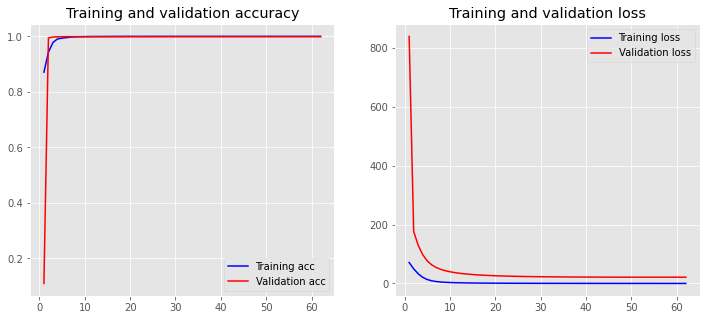

12/12 [==============================] - 5s 169ms/step
F1-score: 90.7%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9059485530546624,0.9074074074074074,0.9066773934030571,1242.0
micro avg,0.9059485530546624,0.9074074074074074,0.9066773934030571,1242.0
macro avg,0.9059485530546624,0.9074074074074074,0.9066773934030571,1242.0
weighted avg,0.9059485530546623,0.9074074074074074,0.9066773934030572,1242.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1903 words (11776 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 545, 100)          1367900   
                                                                 
 bidirectional_4 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,529,312
Trainable params: 1,529,312
Non-trainable 

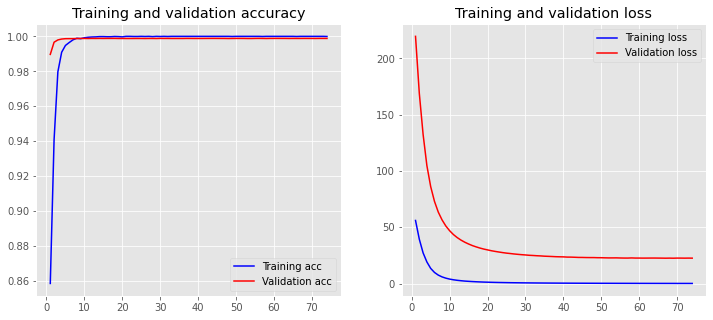

12/12 [==============================] - 5s 173ms/step
F1-score: 90.2%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9079054604726976,0.8969404186795491,0.9023896314297285,1242.0
micro avg,0.9079054604726976,0.8969404186795491,0.9023896314297285,1242.0
macro avg,0.9079054604726976,0.8969404186795491,0.9023896314297285,1242.0
weighted avg,0.9079054604726976,0.8969404186795491,0.9023896314297285,1242.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1896 words (11788 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 545, 100)          1368400   
                                                                 
 bidirectional_5 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,529,812
Trainable params: 1,529,812
Non-trainable 

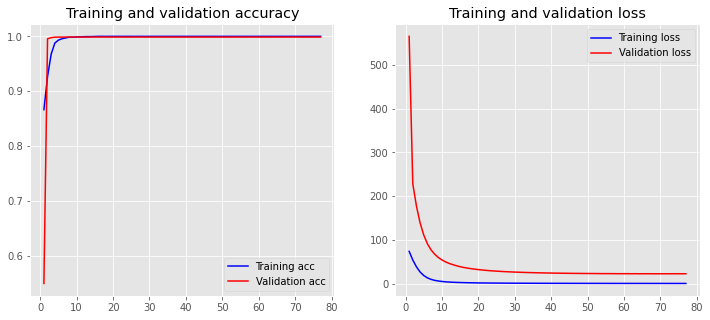

12/12 [==============================] - 5s 172ms/step
F1-score: 90.0%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9013742926434923,0.8977455716586151,0.8995562726906011,1242.0
micro avg,0.9013742926434923,0.8977455716586151,0.8995562726906011,1242.0
macro avg,0.9013742926434923,0.8977455716586151,0.8995562726906011,1242.0
weighted avg,0.9013742926434923,0.8977455716586151,0.8995562726906011,1242.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1904 words (11777 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 545, 100)          1368100   
                                                                 
 bidirectional_6 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,529,512
Trainable params: 1,529,512
Non-trainable 

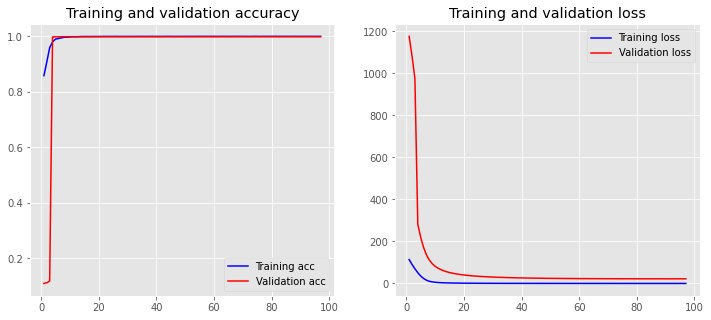

12/12 [==============================] - 5s 168ms/step
F1-score: 89.2%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8788115715402658,0.9049919484702094,0.8917096390321301,1242.0
micro avg,0.8788115715402658,0.9049919484702094,0.8917096390321301,1242.0
macro avg,0.8788115715402658,0.9049919484702094,0.8917096390321301,1242.0
weighted avg,0.8788115715402659,0.9049919484702094,0.8917096390321301,1242.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1914 words (11772 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 545, 100)          1368600   
                                                                 
 bidirectional_7 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,530,012
Trainable params: 1,530,012
Non-trainable 

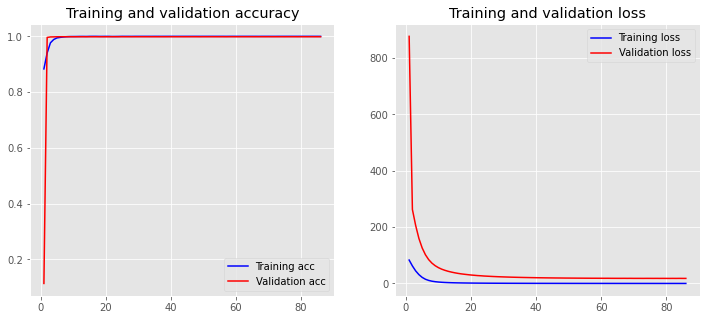

12/12 [==============================] - 5s 169ms/step
F1-score: 89.1%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.889871382636656,0.8913043478260869,0.8905872888173773,1242.0
micro avg,0.889871382636656,0.8913043478260869,0.8905872888173773,1242.0
macro avg,0.889871382636656,0.8913043478260869,0.8905872888173773,1242.0
weighted avg,0.8898713826366559,0.8913043478260869,0.8905872888173773,1242.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1908 words (11799 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 545, 100)          1370700   
                                                                 
 bidirectional_8 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,532,112
Trainable params: 1,532,112
Non-trainable 

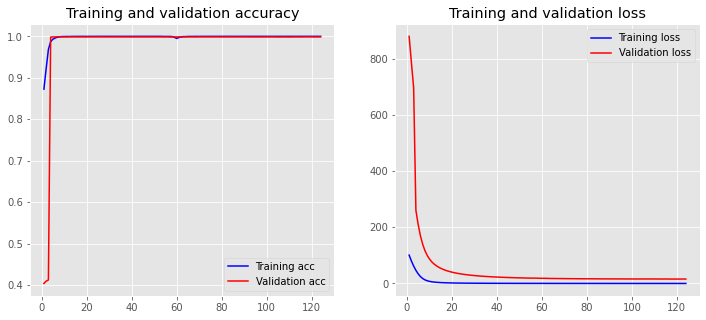

12/12 [==============================] - 5s 170ms/step
F1-score: 89.1%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9012345679012346,0.8816425120772947,0.8913308913308914,1242.0
micro avg,0.9012345679012346,0.8816425120772947,0.8913308913308914,1242.0
macro avg,0.9012345679012346,0.8816425120772947,0.8913308913308914,1242.0
weighted avg,0.9012345679012345,0.8816425120772947,0.8913308913308913,1242.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 1922 words (11783 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 545, 100)          1370500   
                                                                 
 bidirectional_9 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,531,912
Trainable params: 1,531,912
Non-trainable 

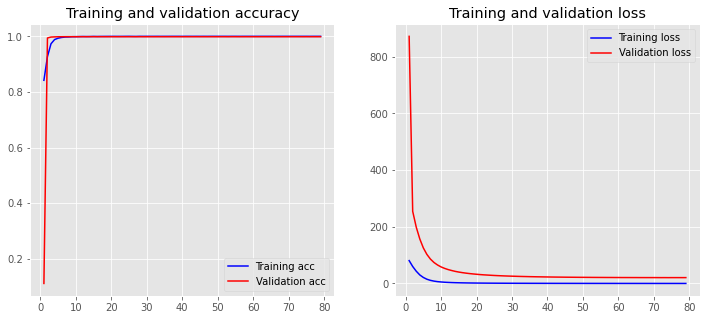

12/12 [==============================] - 5s 169ms/step
F1-score: 90.3%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8967434471803019,0.9090177133655395,0.9028388644542183,1242.0
micro avg,0.8967434471803019,0.9090177133655395,0.9028388644542183,1242.0
macro avg,0.8967434471803019,0.9090177133655395,0.9028388644542183,1242.0
weighted avg,0.8967434471803019,0.9090177133655395,0.9028388644542182,1242.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1940 words (11821 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 545, 100)          1376100   
                                                                 
 bidirectional_10 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,537,512
Trainable params: 1,537,512
Non-trainable

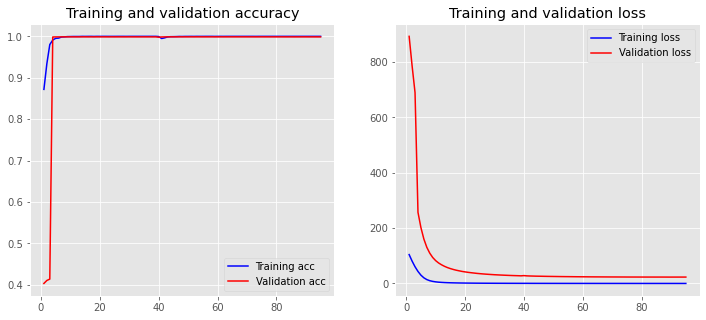

12/12 [==============================] - 5s 171ms/step
F1-score: 88.5%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9001663893510815,0.8711755233494364,0.8854337152209493,1242.0
micro avg,0.9001663893510815,0.8711755233494364,0.8854337152209493,1242.0
macro avg,0.9001663893510815,0.8711755233494364,0.8854337152209493,1242.0
weighted avg,0.9001663893510815,0.8711755233494364,0.8854337152209493,1242.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1926 words (11856 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 545, 100)          1378200   
                                                                 
 bidirectional_11 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,539,612
Trainable params: 1,539,612
Non-trainable

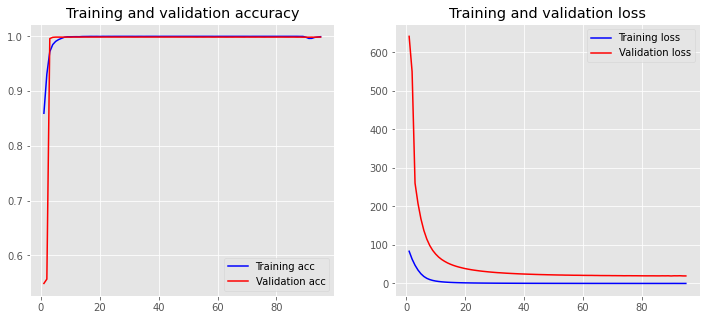

12/12 [==============================] - 5s 174ms/step
F1-score: 86.4%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8480620155038759,0.8808373590982287,0.8641390205371248,1242.0
micro avg,0.8480620155038759,0.8808373590982287,0.8641390205371248,1242.0
macro avg,0.8480620155038759,0.8808373590982287,0.8641390205371248,1242.0
weighted avg,0.8480620155038759,0.8808373590982287,0.8641390205371248,1242.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1943 words (11833 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 545, 100)          1377600   
                                                                 
 bidirectional_12 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,539,012
Trainable params: 1,539,012
Non-trainable

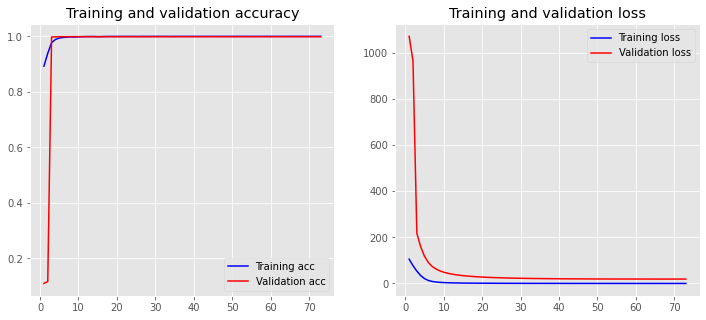

12/12 [==============================] - 5s 167ms/step
F1-score: 88.5%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8760852407261247,0.893719806763285,0.8848146671980869,1242.0
micro avg,0.8760852407261247,0.893719806763285,0.8848146671980869,1242.0
macro avg,0.8760852407261247,0.893719806763285,0.8848146671980869,1242.0
weighted avg,0.8760852407261247,0.893719806763285,0.884814667198087,1242.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1927 words (11836 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 545, 100)          1376300   
                                                                 
 bidirectional_13 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,537,712
Trainable params: 1,537,712
Non-trainable

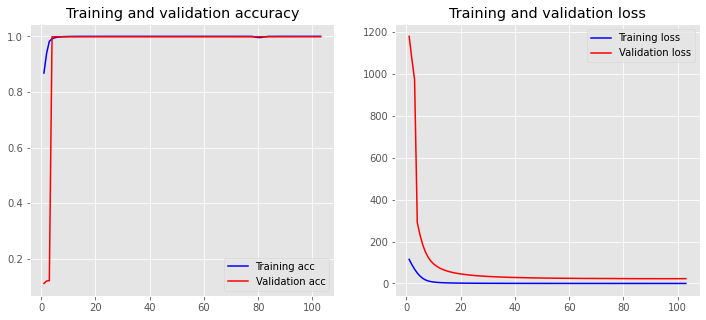

12/12 [==============================] - 5s 167ms/step
F1-score: 89.3%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8968318440292445,0.8888888888888888,0.8928427011726647,1242.0
micro avg,0.8968318440292445,0.8888888888888888,0.8928427011726647,1242.0
macro avg,0.8968318440292445,0.8888888888888888,0.8928427011726647,1242.0
weighted avg,0.8968318440292445,0.8888888888888888,0.8928427011726647,1242.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1918 words (11826 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 545, 100)          1374400   
                                                                 
 bidirectional_14 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,535,812
Trainable params: 1,535,812
Non-trainable

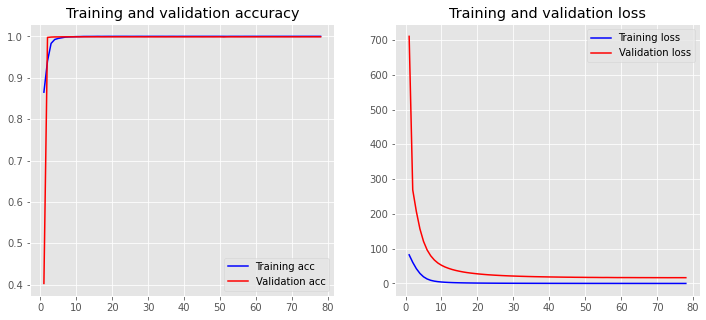

12/12 [==============================] - 5s 171ms/step
F1-score: 91.6%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9168684422921711,0.9146537842190016,0.9157597742845627,1242.0
micro avg,0.9168684422921711,0.9146537842190016,0.9157597742845627,1242.0
macro avg,0.9168684422921711,0.9146537842190016,0.9157597742845627,1242.0
weighted avg,0.916868442292171,0.9146537842190016,0.9157597742845626,1242.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1908 words (11827 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 545, 100)          1373500   
                                                                 
 bidirectional_15 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,534,912
Trainable params: 1,534,912
Non-trainable

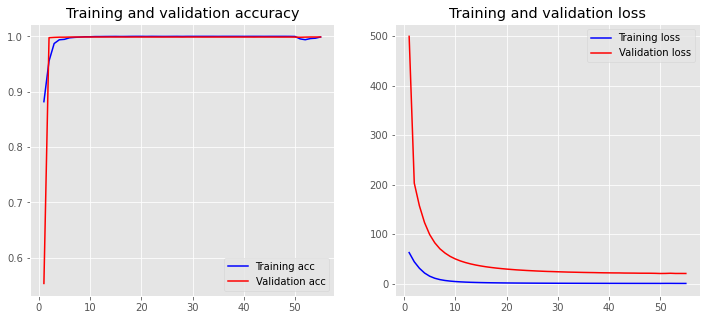

12/12 [==============================] - 5s 173ms/step
F1-score: 89.6%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8742331288343558,0.9178743961352657,0.8955223880597015,1242.0
micro avg,0.8742331288343558,0.9178743961352657,0.8955223880597015,1242.0
macro avg,0.8742331288343558,0.9178743961352657,0.8955223880597015,1242.0
weighted avg,0.8742331288343557,0.9178743961352657,0.8955223880597015,1242.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1922 words (11834 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 545, 100)          1375600   
                                                                 
 bidirectional_16 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,537,012
Trainable params: 1,537,012
Non-trainable

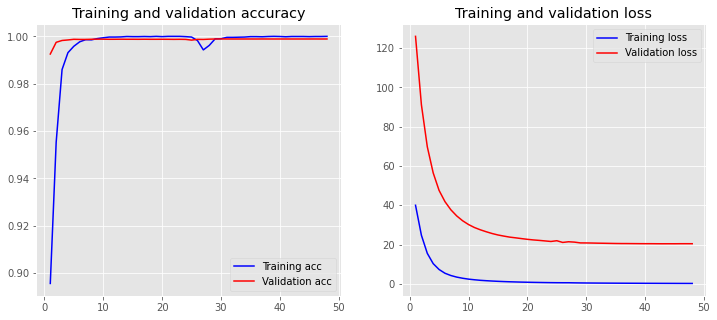

12/12 [==============================] - 5s 174ms/step
F1-score: 91.7%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9318936877076412,0.9033816425120773,0.9174161896974654,1242.0
micro avg,0.9318936877076412,0.9033816425120773,0.9174161896974654,1242.0
macro avg,0.9318936877076412,0.9033816425120773,0.9174161896974654,1242.0
weighted avg,0.9318936877076412,0.9033816425120773,0.9174161896974654,1242.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1950 words (11831 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 545, 100)          1378100   
                                                                 
 bidirectional_17 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,539,512
Trainable params: 1,539,512
Non-trainable

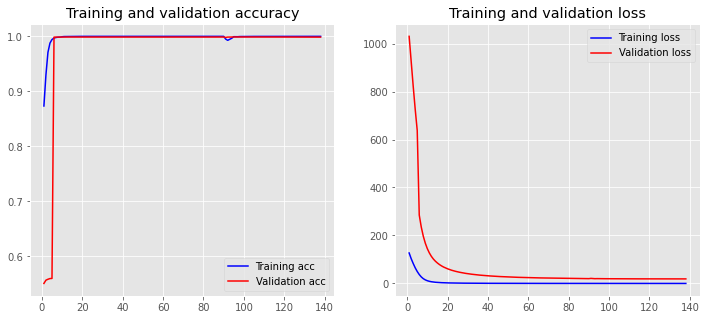

12/12 [==============================] - 5s 173ms/step
F1-score: 89.1%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9059900166389351,0.8768115942028986,0.8911620294599017,1242.0
micro avg,0.9059900166389351,0.8768115942028986,0.8911620294599017,1242.0
macro avg,0.9059900166389351,0.8768115942028986,0.8911620294599017,1242.0
weighted avg,0.9059900166389351,0.8768115942028986,0.8911620294599016,1242.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1925 words (11809 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 545, 100)          1373400   
                                                                 
 bidirectional_18 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,534,812
Trainable params: 1,534,812
Non-trainable

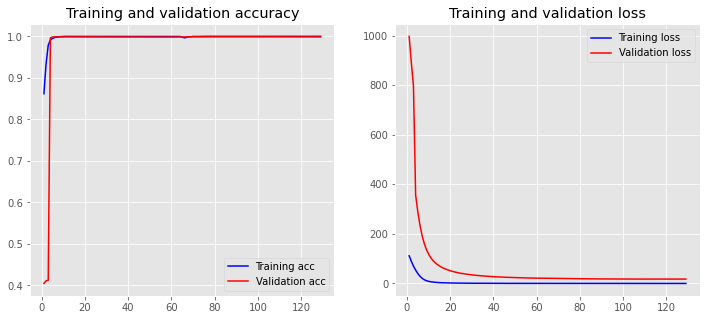

12/12 [==============================] - 5s 182ms/step
F1-score: 90.9%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9130081300813008,0.9041867954911433,0.9085760517799353,1242.0
micro avg,0.9130081300813008,0.9041867954911433,0.9085760517799353,1242.0
macro avg,0.9130081300813008,0.9041867954911433,0.9085760517799353,1242.0
weighted avg,0.9130081300813009,0.9041867954911433,0.9085760517799352,1242.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 1933 words (11831 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 545, 100)          1376400   
                                                                 
 bidirectional_19 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,537,812
Trainable params: 1,537,812
Non-trainable

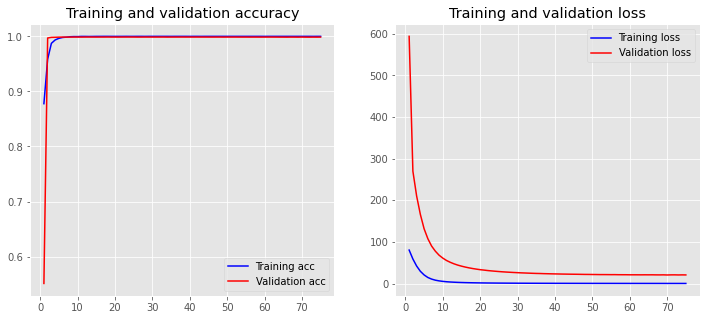

12/12 [==============================] - 5s 172ms/step
F1-score: 88.0%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8850855745721271,0.8743961352657005,0.8797083839611177,1242.0
micro avg,0.8850855745721271,0.8743961352657005,0.8797083839611177,1242.0
macro avg,0.8850855745721271,0.8743961352657005,0.8797083839611177,1242.0
weighted avg,0.8850855745721271,0.8743961352657005,0.8797083839611177,1242.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1949 words (11856 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 545, 100)          1380500   
                                                                 
 bidirectional_20 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,541,912
Trainable params: 1,541,912
Non-trainable

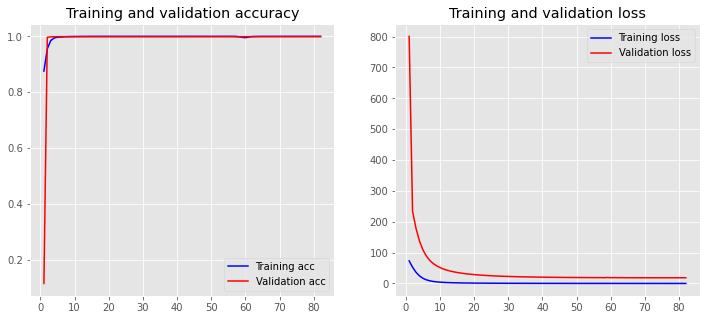

12/12 [==============================] - 5s 172ms/step
F1-score: 90.2%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9038772213247173,0.9009661835748792,0.9024193548387096,1242.0
micro avg,0.9038772213247173,0.9009661835748792,0.9024193548387096,1242.0
macro avg,0.9038772213247173,0.9009661835748792,0.9024193548387096,1242.0
weighted avg,0.9038772213247173,0.9009661835748792,0.9024193548387096,1242.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1956 words (11855 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 545, 100)          1381100   
                                                                 
 bidirectional_21 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,542,512
Trainable params: 1,542,512
Non-trainable

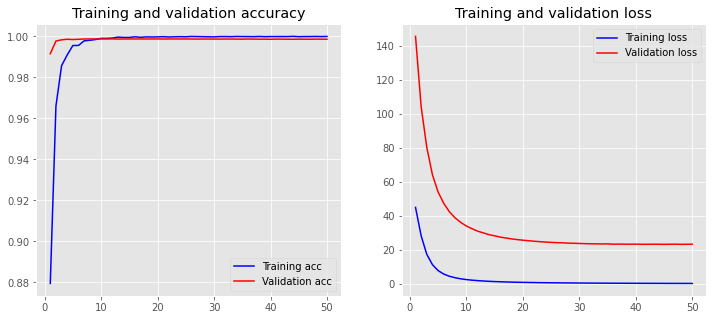

12/12 [==============================] - 5s 174ms/step
F1-score: 87.9%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.873015873015873,0.8856682769726248,0.8792965627498002,1242.0
micro avg,0.873015873015873,0.8856682769726248,0.8792965627498002,1242.0
macro avg,0.873015873015873,0.8856682769726248,0.8792965627498002,1242.0
weighted avg,0.8730158730158729,0.8856682769726248,0.8792965627498003,1242.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1938 words (11845 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 545, 100)          1378300   
                                                                 
 bidirectional_22 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,539,712
Trainable params: 1,539,712
Non-trainable

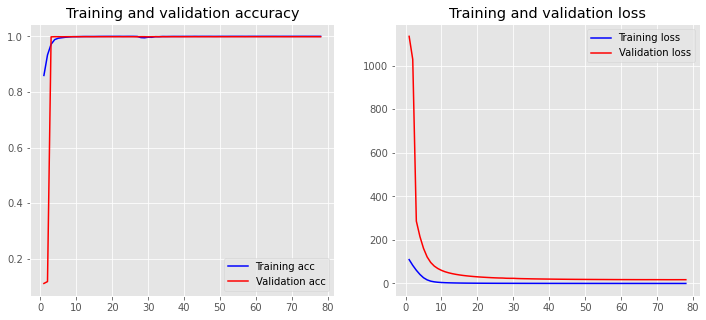

12/12 [==============================] - 5s 175ms/step
F1-score: 87.8%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8886138613861386,0.8671497584541062,0.8777506112469438,1242.0
micro avg,0.8886138613861386,0.8671497584541062,0.8777506112469438,1242.0
macro avg,0.8886138613861386,0.8671497584541062,0.8777506112469438,1242.0
weighted avg,0.8886138613861386,0.8671497584541062,0.8777506112469436,1242.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1958 words (11868 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 545, 100)          1382600   
                                                                 
 bidirectional_23 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,544,012
Trainable params: 1,544,012
Non-trainable

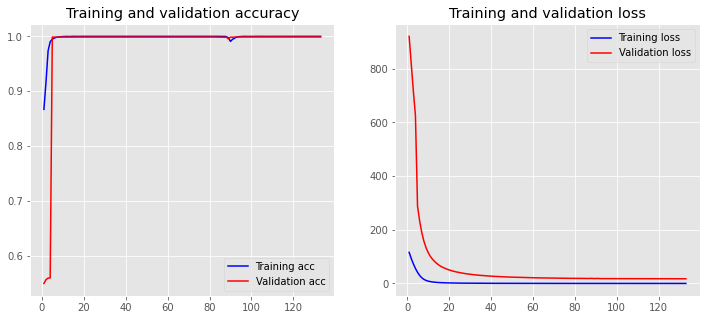

12/12 [==============================] - 5s 170ms/step
F1-score: 88.2%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8948675496688742,0.8703703703703703,0.8824489795918368,1242.0
micro avg,0.8948675496688742,0.8703703703703703,0.8824489795918368,1242.0
macro avg,0.8948675496688742,0.8703703703703703,0.8824489795918368,1242.0
weighted avg,0.8948675496688742,0.8703703703703703,0.8824489795918368,1242.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1956 words (11847 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 545, 100)          1380300   
                                                                 
 bidirectional_24 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,541,712
Trainable params: 1,541,712
Non-trainable

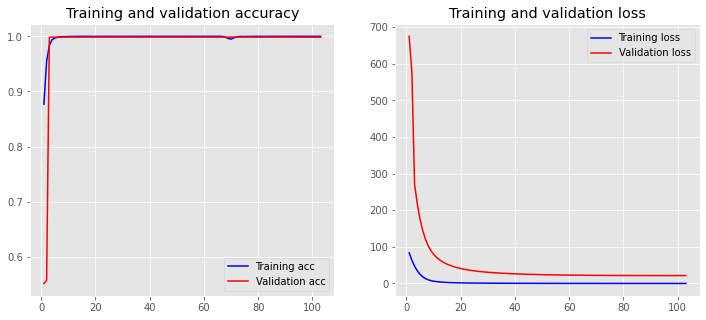

12/12 [==============================] - 5s 168ms/step
F1-score: 87.8%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8961474036850922,0.8615136876006442,0.8784893267651889,1242.0
micro avg,0.8961474036850922,0.8615136876006442,0.8784893267651889,1242.0
macro avg,0.8961474036850922,0.8615136876006442,0.8784893267651889,1242.0
weighted avg,0.8961474036850922,0.8615136876006442,0.8784893267651889,1242.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1940 words (11860 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 545, 100)          1380000   
                                                                 
 bidirectional_25 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,541,412
Trainable params: 1,541,412
Non-trainable

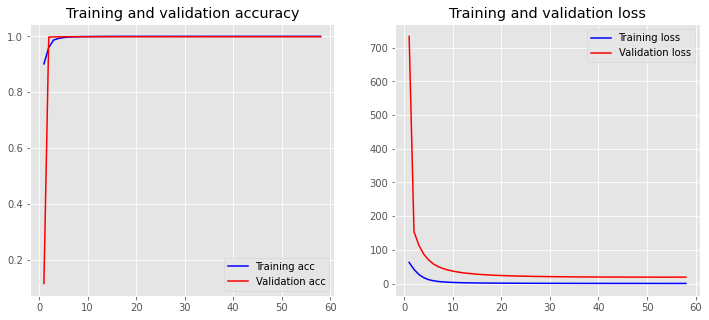

12/12 [==============================] - 5s 173ms/step
F1-score: 90.3%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9079804560260586,0.8977455716586151,0.902834008097166,1242.0
micro avg,0.9079804560260586,0.8977455716586151,0.902834008097166,1242.0
macro avg,0.9079804560260586,0.8977455716586151,0.902834008097166,1242.0
weighted avg,0.9079804560260586,0.8977455716586151,0.9028340080971659,1242.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1946 words (11879 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 545, 100)          1382500   
                                                                 
 bidirectional_26 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,543,912
Trainable params: 1,543,912
Non-trainable

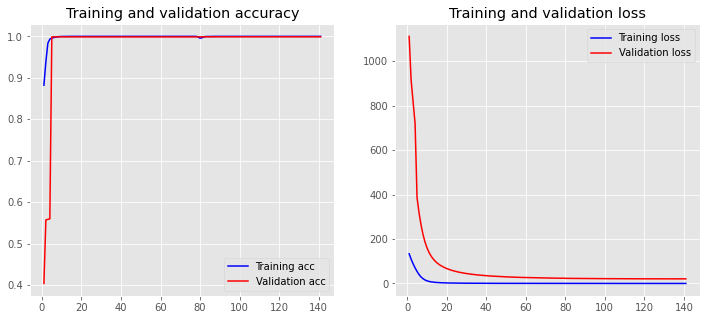

12/12 [==============================] - 5s 174ms/step
F1-score: 87.7%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.885784716516023,0.8679549114331723,0.8767791785278568,1242.0
micro avg,0.885784716516023,0.8679549114331723,0.8767791785278568,1242.0
macro avg,0.885784716516023,0.8679549114331723,0.8767791785278568,1242.0
weighted avg,0.8857847165160229,0.8679549114331723,0.8767791785278568,1242.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1945 words (11855 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 545, 100)          1380000   
                                                                 
 bidirectional_27 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,541,412
Trainable params: 1,541,412
Non-trainable

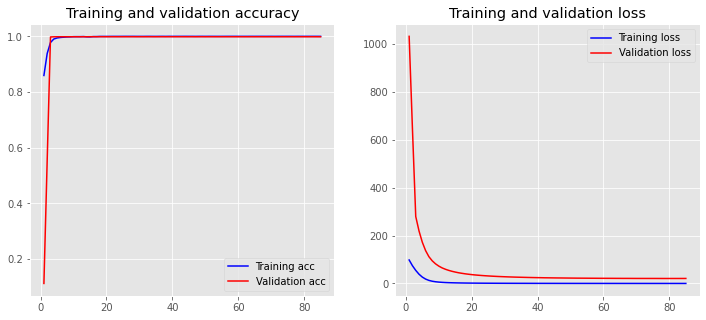

12/12 [==============================] - 5s 183ms/step
F1-score: 87.5%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8815359477124183,0.8687600644122383,0.8751013787510139,1242.0
micro avg,0.8815359477124183,0.8687600644122383,0.8751013787510139,1242.0
macro avg,0.8815359477124183,0.8687600644122383,0.8751013787510139,1242.0
weighted avg,0.8815359477124182,0.8687600644122383,0.8751013787510138,1242.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1966 words (11881 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 545, 100)          1384700   
                                                                 
 bidirectional_28 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,546,112
Trainable params: 1,546,112
Non-trainable

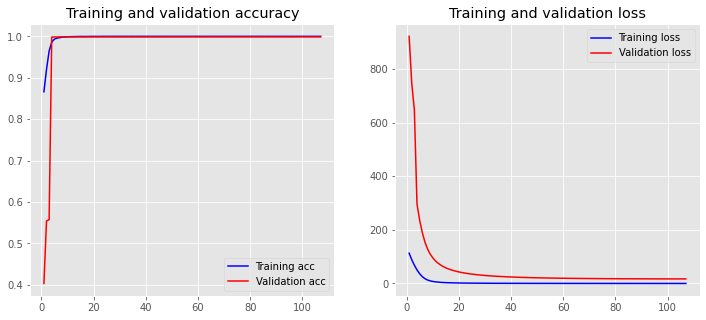

12/12 [==============================] - 5s 169ms/step
F1-score: 89.5%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8914604948124502,0.8993558776167472,0.8953907815631263,1242.0
micro avg,0.8914604948124502,0.8993558776167472,0.8953907815631263,1242.0
macro avg,0.8914604948124502,0.8993558776167472,0.8953907815631263,1242.0
weighted avg,0.8914604948124502,0.8993558776167472,0.8953907815631262,1242.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 1943 words (11856 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 545, 100)          1379900   
                                                                 
 bidirectional_29 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,541,312
Trainable params: 1,541,312
Non-trainable

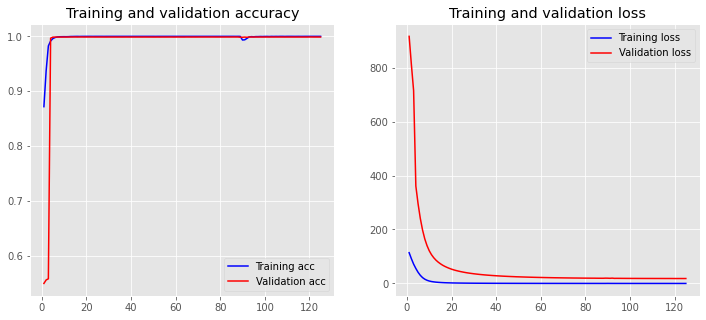

12/12 [==============================] - 5s 174ms/step
F1-score: 90.2%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.919732441471572,0.8856682769726248,0.9023789991796555,1242.0
micro avg,0.919732441471572,0.8856682769726248,0.9023789991796555,1242.0
macro avg,0.919732441471572,0.8856682769726248,0.9023789991796555,1242.0
weighted avg,0.919732441471572,0.8856682769726248,0.9023789991796555,1242.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1979 words (11895 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 545, 100)          1387400   
                                                                 
 bidirectional_30 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,548,812
Trainable params: 1,548,812
Non-trainable

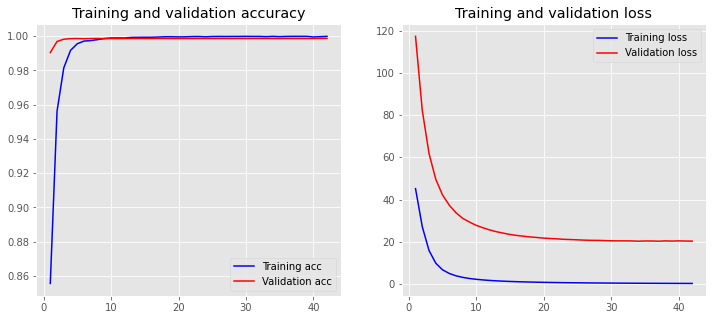

12/12 [==============================] - 5s 175ms/step
F1-score: 88.7%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8814638027048528,0.8921095008051529,0.8867547018807521,1242.0
micro avg,0.8814638027048528,0.8921095008051529,0.8867547018807521,1242.0
macro avg,0.8814638027048528,0.8921095008051529,0.8867547018807521,1242.0
weighted avg,0.8814638027048528,0.8921095008051529,0.8867547018807521,1242.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1952 words (11890 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 545, 100)          1384200   
                                                                 
 bidirectional_31 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,545,612
Trainable params: 1,545,612
Non-trainable

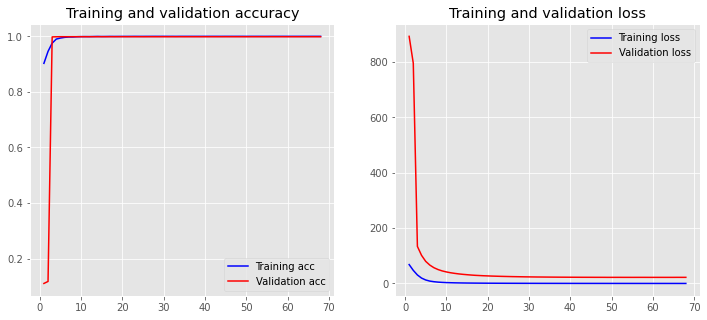

12/12 [==============================] - 5s 167ms/step
F1-score: 88.2%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8805132317562149,0.8840579710144928,0.8822820409803135,1242.0
micro avg,0.8805132317562149,0.8840579710144928,0.8822820409803135,1242.0
macro avg,0.8805132317562149,0.8840579710144928,0.8822820409803135,1242.0
weighted avg,0.8805132317562149,0.8840579710144928,0.8822820409803136,1242.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1972 words (11921 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 545, 100)          1389300   
                                                                 
 bidirectional_32 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,550,712
Trainable params: 1,550,712
Non-trainable

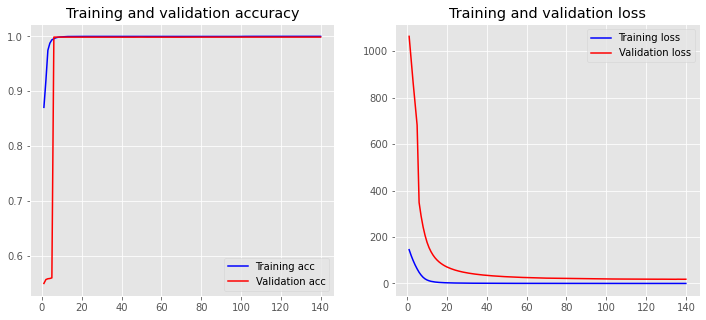

12/12 [==============================] - 5s 170ms/step
F1-score: 88.8%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8823529411764706,0.893719806763285,0.888,1242.0
micro avg,0.8823529411764706,0.893719806763285,0.888,1242.0
macro avg,0.8823529411764706,0.893719806763285,0.888,1242.0
weighted avg,0.8823529411764705,0.893719806763285,0.888,1242.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1966 words (11903 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 545, 100)          1386900   
                                                                 
 bidirectional_33 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,548,312
Trainable params: 1,548,312
Non-trainable

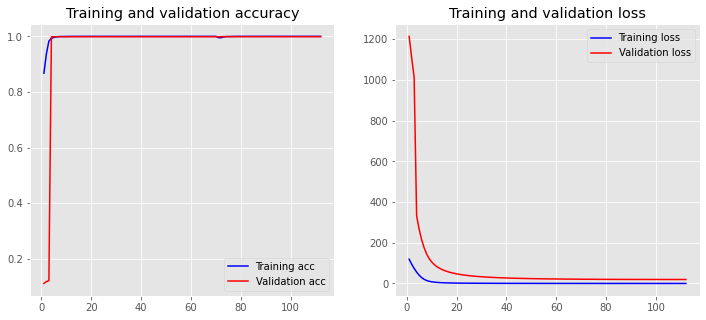

12/12 [==============================] - 5s 170ms/step
F1-score: 89.4%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9106844741235393,0.8784219001610306,0.8942622950819672,1242.0
micro avg,0.9106844741235393,0.8784219001610306,0.8942622950819672,1242.0
macro avg,0.9106844741235393,0.8784219001610306,0.8942622950819672,1242.0
weighted avg,0.9106844741235393,0.8784219001610306,0.8942622950819672,1242.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1961 words (11904 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 545, 100)          1386500   
                                                                 
 bidirectional_34 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,547,912
Trainable params: 1,547,912
Non-trainable

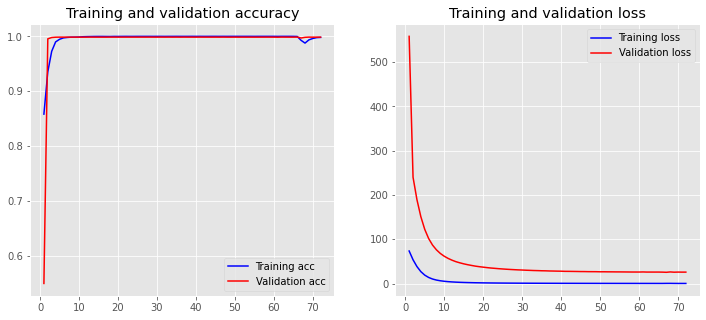

12/12 [==============================] - 5s 171ms/step
F1-score: 79.6%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.7112944162436549,0.9025764895330113,0.7955997161107169,1242.0
micro avg,0.7112944162436549,0.9025764895330113,0.7955997161107169,1242.0
macro avg,0.7112944162436549,0.9025764895330113,0.7955997161107169,1242.0
weighted avg,0.7112944162436549,0.9025764895330113,0.7955997161107169,1242.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1960 words (11898 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 545, 100)          1385800   
                                                                 
 bidirectional_35 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,547,212
Trainable params: 1,547,212
Non-trainable

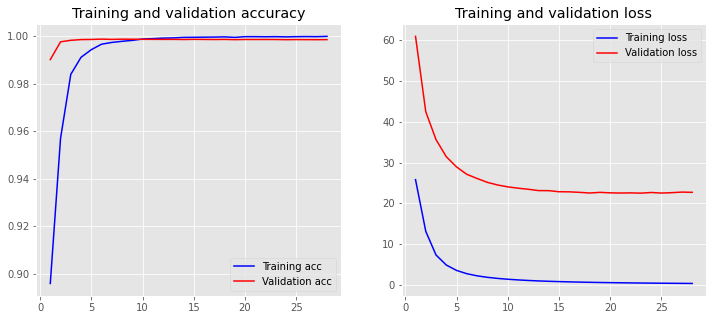

12/12 [==============================] - 5s 169ms/step
F1-score: 86.8%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8607594936708861,0.8760064412238325,0.8683160415003991,1242.0
micro avg,0.8607594936708861,0.8760064412238325,0.8683160415003991,1242.0
macro avg,0.8607594936708861,0.8760064412238325,0.8683160415003991,1242.0
weighted avg,0.8607594936708861,0.8760064412238325,0.8683160415003991,1242.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1973 words (11877 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 545, 100)          1385000   
                                                                 
 bidirectional_36 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,546,412
Trainable params: 1,546,412
Non-trainable

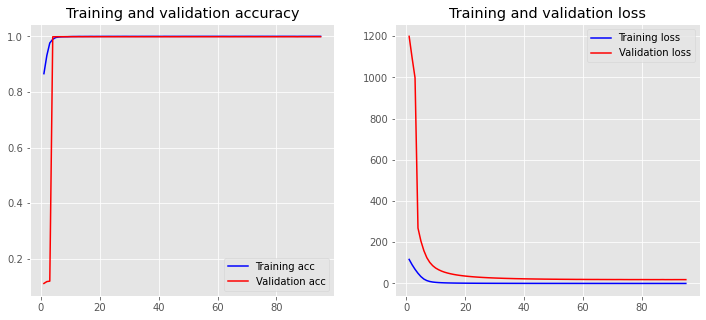

12/12 [==============================] - 5s 173ms/step
F1-score: 88.5%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8816946442845723,0.8880837359098228,0.8848776574408344,1242.0
micro avg,0.8816946442845723,0.8880837359098228,0.8848776574408344,1242.0
macro avg,0.8816946442845723,0.8880837359098228,0.8848776574408344,1242.0
weighted avg,0.8816946442845722,0.8880837359098228,0.8848776574408344,1242.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1962 words (11908 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 545, 100)          1387000   
                                                                 
 bidirectional_37 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,548,412
Trainable params: 1,548,412
Non-trainable

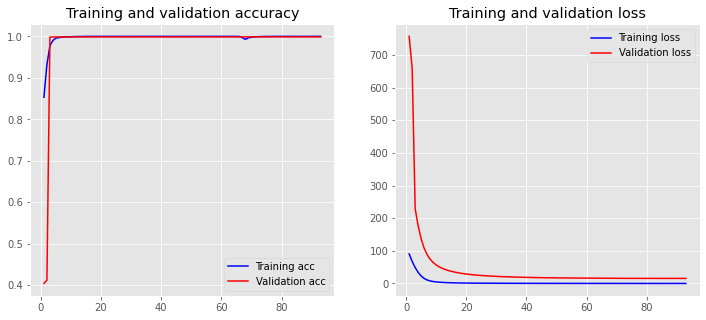

12/12 [==============================] - 5s 170ms/step
F1-score: 88.5%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9015025041736227,0.8695652173913043,0.8852459016393444,1242.0
micro avg,0.9015025041736227,0.8695652173913043,0.8852459016393444,1242.0
macro avg,0.9015025041736227,0.8695652173913043,0.8852459016393444,1242.0
weighted avg,0.9015025041736227,0.8695652173913043,0.8852459016393444,1242.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1959 words (11897 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 545, 100)          1385600   
                                                                 
 bidirectional_38 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,547,012
Trainable params: 1,547,012
Non-trainable

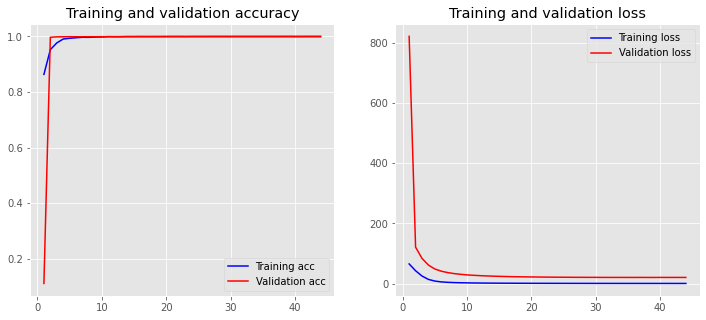

12/12 [==============================] - 5s 167ms/step
F1-score: 87.8%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8821138211382114,0.8735909822866345,0.877831715210356,1242.0
micro avg,0.8821138211382114,0.8735909822866345,0.877831715210356,1242.0
macro avg,0.8821138211382114,0.8735909822866345,0.877831715210356,1242.0
weighted avg,0.8821138211382114,0.8735909822866345,0.877831715210356,1242.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 1968 words (11889 misses)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 545, 100)          1385700   
                                                                 
 bidirectional_39 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_39 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,547,112
Trainable params: 1,547,112
Non-trainable

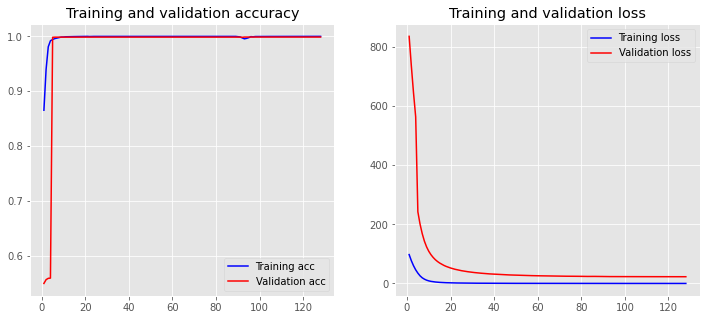

12/12 [==============================] - 6s 192ms/step
F1-score: 88.8%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8905996758508914,0.8848631239935588,0.8877221324717285,1242.0
micro avg,0.8905996758508914,0.8848631239935588,0.8877221324717285,1242.0
macro avg,0.8905996758508914,0.8848631239935588,0.8877221324717285,1242.0
weighted avg,0.8905996758508914,0.8848631239935588,0.8877221324717285,1242.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 2016 words (12003 misses)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 545, 100)          1401900   
                                                                 
 bidirectional_40 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,563,312
Trainable params: 1,563,312
Non-trainable

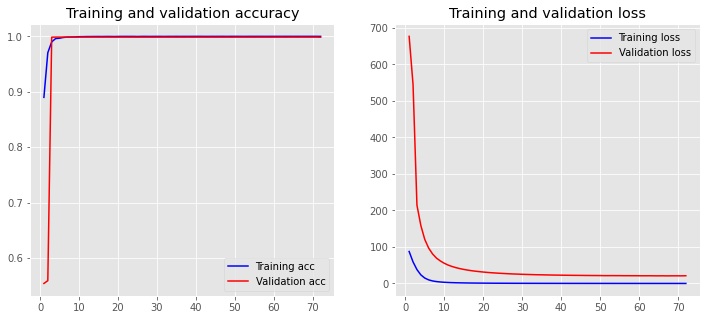

12/12 [==============================] - 5s 191ms/step
F1-score: 86.9%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8687600644122383,0.8687600644122383,0.8687600644122383,1242.0
micro avg,0.8687600644122383,0.8687600644122383,0.8687600644122383,1242.0
macro avg,0.8687600644122383,0.8687600644122383,0.8687600644122383,1242.0
weighted avg,0.8687600644122383,0.8687600644122383,0.8687600644122383,1242.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 2011 words (12007 misses)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 545, 100)          1401800   
                                                                 
 bidirectional_41 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_41 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_41 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,563,212
Trainable params: 1,563,212
Non-trainable

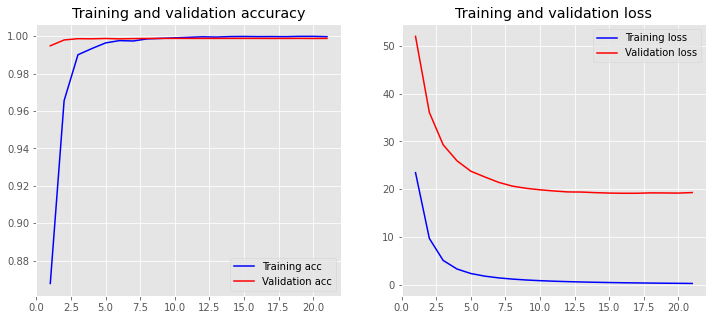

12/12 [==============================] - 5s 184ms/step
F1-score: 88.7%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8911454102355808,0.8832528180354268,0.8871815608572583,1242.0
micro avg,0.8911454102355808,0.8832528180354268,0.8871815608572583,1242.0
macro avg,0.8911454102355808,0.8832528180354268,0.8871815608572583,1242.0
weighted avg,0.8911454102355808,0.8832528180354268,0.8871815608572583,1242.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 1998 words (11979 misses)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 545, 100)          1397700   
                                                                 
 bidirectional_42 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_42 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_42 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,559,112
Trainable params: 1,559,112
Non-trainable

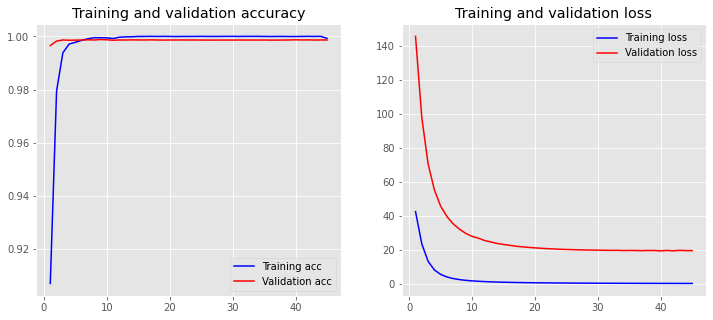

12/12 [==============================] - 5s 182ms/step
F1-score: 88.6%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.884430176565008,0.8872785829307569,0.8858520900321545,1242.0
micro avg,0.884430176565008,0.8872785829307569,0.8858520900321545,1242.0
macro avg,0.884430176565008,0.8872785829307569,0.8858520900321545,1242.0
weighted avg,0.8844301765650081,0.8872785829307569,0.8858520900321546,1242.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 2011 words (11981 misses)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 545, 100)          1399200   
                                                                 
 bidirectional_43 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_43 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_43 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,560,612
Trainable params: 1,560,612
Non-trainable

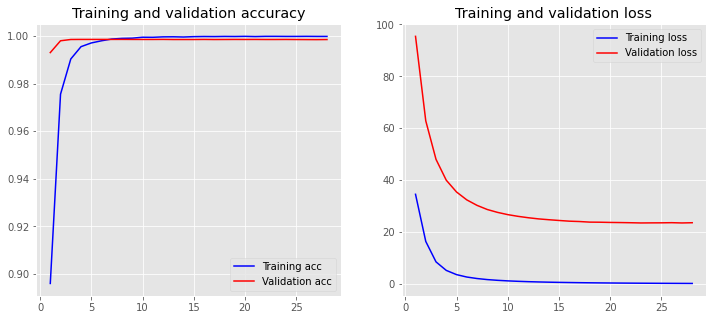

12/12 [==============================] - 5s 181ms/step
F1-score: 87.2%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8689048760991207,0.8752012882447665,0.8720417168070598,1242.0
micro avg,0.8689048760991207,0.8752012882447665,0.8720417168070598,1242.0
macro avg,0.8689048760991207,0.8752012882447665,0.8720417168070598,1242.0
weighted avg,0.8689048760991207,0.8752012882447665,0.8720417168070598,1242.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 2033 words (11977 misses)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 545, 100)          1401000   
                                                                 
 bidirectional_44 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_44 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_44 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,562,412
Trainable params: 1,562,412
Non-trainable

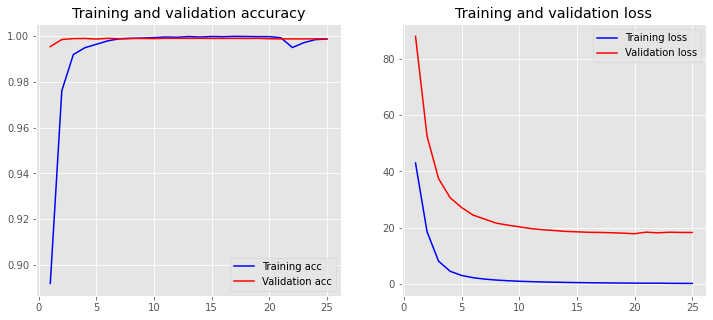

12/12 [==============================] - 5s 174ms/step
F1-score: 89.4%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8816614420062696,0.9057971014492754,0.8935663224781573,1242.0
micro avg,0.8816614420062696,0.9057971014492754,0.8935663224781573,1242.0
macro avg,0.8816614420062696,0.9057971014492754,0.8935663224781573,1242.0
weighted avg,0.8816614420062696,0.9057971014492754,0.8935663224781571,1242.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 2028 words (12016 misses)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 545, 100)          1404400   
                                                                 
 bidirectional_45 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_45 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_45 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,565,812
Trainable params: 1,565,812
Non-trainable

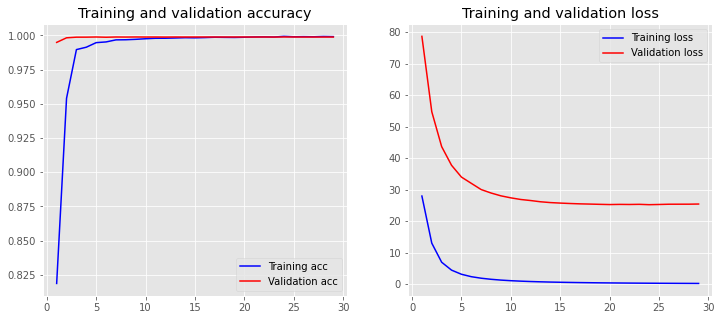

12/12 [==============================] - 5s 178ms/step
F1-score: 89.1%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8958502847843776,0.8864734299516909,0.8911371914204775,1242.0
micro avg,0.8958502847843776,0.8864734299516909,0.8911371914204775,1242.0
macro avg,0.8958502847843776,0.8864734299516909,0.8911371914204775,1242.0
weighted avg,0.8958502847843776,0.8864734299516909,0.8911371914204775,1242.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 2014 words (12006 misses)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 545, 100)          1402000   
                                                                 
 bidirectional_46 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_46 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_46 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,563,412
Trainable params: 1,563,412
Non-trainable

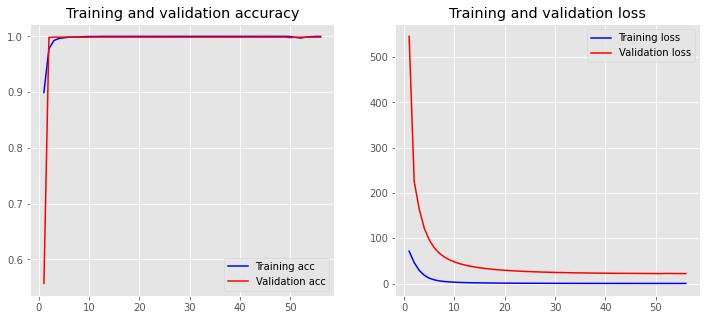

12/12 [==============================] - 6s 181ms/step
F1-score: 86.5%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.85003885003885,0.8808373590982287,0.8651640964808226,1242.0
micro avg,0.85003885003885,0.8808373590982287,0.8651640964808226,1242.0
macro avg,0.85003885003885,0.8808373590982287,0.8651640964808226,1242.0
weighted avg,0.85003885003885,0.8808373590982287,0.8651640964808225,1242.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 2022 words (12029 misses)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 545, 100)          1405100   
                                                                 
 bidirectional_47 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_47 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_47 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,566,512
Trainable params: 1,566,512
Non-trainable

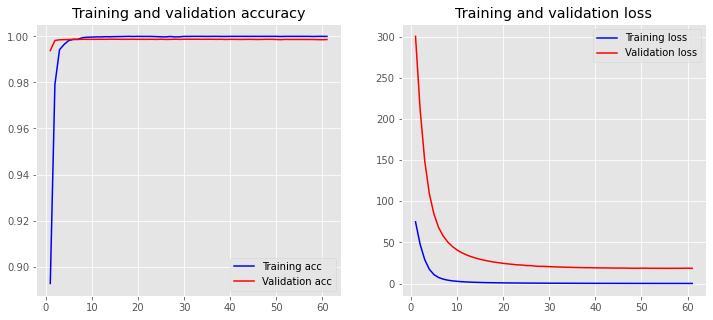

12/12 [==============================] - 5s 176ms/step
F1-score: 88.2%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8941273779983457,0.8703703703703703,0.8820889432884537,1242.0
micro avg,0.8941273779983457,0.8703703703703703,0.8820889432884537,1242.0
macro avg,0.8941273779983457,0.8703703703703703,0.8820889432884537,1242.0
weighted avg,0.8941273779983456,0.8703703703703703,0.8820889432884538,1242.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 2031 words (11993 misses)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 545, 100)          1402400   
                                                                 
 bidirectional_48 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_48 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_48 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,563,812
Trainable params: 1,563,812
Non-trainable

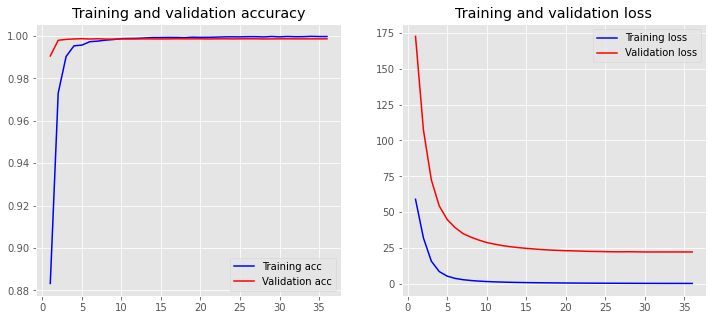

12/12 [==============================] - 5s 189ms/step
F1-score: 87.7%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8794498381877023,0.8752012882447665,0.877320419693301,1242.0
micro avg,0.8794498381877023,0.8752012882447665,0.877320419693301,1242.0
macro avg,0.8794498381877023,0.8752012882447665,0.877320419693301,1242.0
weighted avg,0.8794498381877022,0.8752012882447665,0.877320419693301,1242.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 2018 words (12015 misses)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 545, 100)          1403300   
                                                                 
 bidirectional_49 (Bidirecti  (None, 545, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_49 (TimeDi  (None, 545, 3)           603       
 stributed)                                                      
                                                                 
 crf_49 (CRF)                (None, 545, 3)            9         
                                                                 
Total params: 1,564,712
Trainable params: 1,564,712
Non-trainable

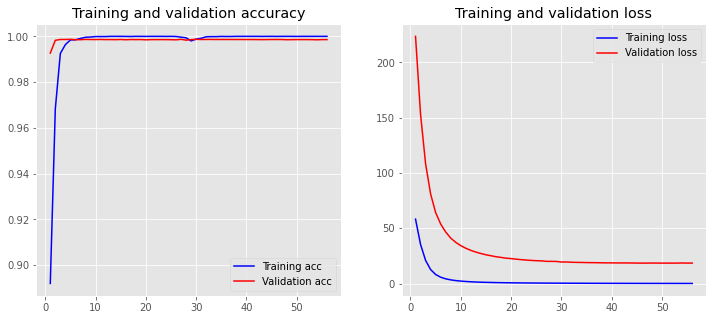

12/12 [==============================] - 5s 181ms/step
F1-score: 88.5%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9099405267629567,0.8623188405797102,0.885489871847871,1242.0
micro avg,0.9099405267629567,0.8623188405797102,0.885489871847871,1242.0
macro avg,0.9099405267629567,0.8623188405797102,0.885489871847871,1242.0
weighted avg,0.9099405267629567,0.8623188405797102,0.8854898718478711,1242.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2129 words (12197 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 545, 100)          1432600   
                                                                 
 bidirectional (Bidirectiona  (None, 545, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 545, 3)           603       
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 545, 3)            9         
                                                                 
Total params: 1,594,012
Trainable params: 1,594,012
Non-trainable pa

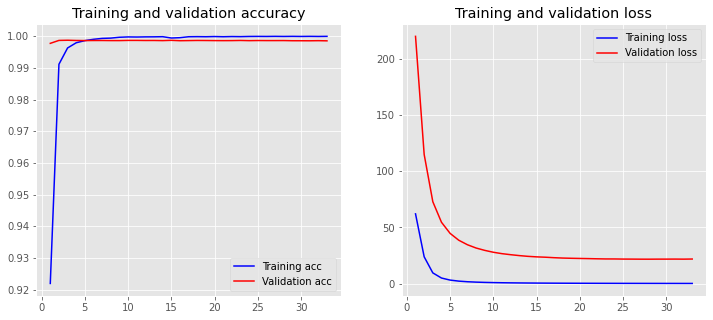

12/12 [==============================] - 5s 176ms/step
F1-score: 86.3%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8686786296900489,0.857487922705314,0.8630470016207455,1242.0
micro avg,0.8686786296900489,0.857487922705314,0.8630470016207455,1242.0
macro avg,0.8686786296900489,0.857487922705314,0.8630470016207455,1242.0
weighted avg,0.8686786296900489,0.857487922705314,0.8630470016207455,1242.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2125 words (12180 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 545, 100)          1430500   
                                                                 
 bidirectional_1 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,591,912
Trainable params: 1,591,912
Non-trainable 

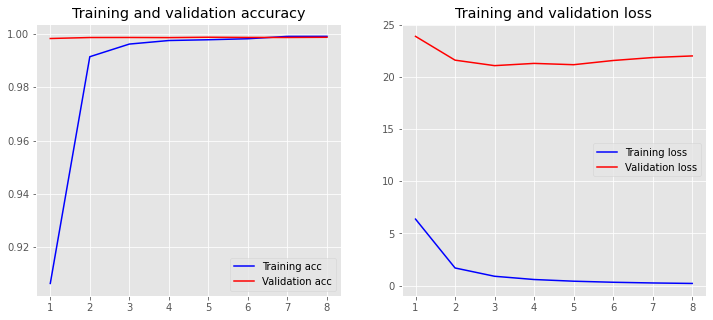

12/12 [==============================] - 5s 172ms/step
F1-score: 89.4%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9085619285120532,0.8800322061191627,0.8940695296523518,1242.0
micro avg,0.9085619285120532,0.8800322061191627,0.8940695296523518,1242.0
macro avg,0.9085619285120532,0.8800322061191627,0.8940695296523518,1242.0
weighted avg,0.9085619285120532,0.8800322061191627,0.8940695296523519,1242.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2086 words (12207 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 545, 100)          1429300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,590,712
Trainable params: 1,590,712
Non-trainable 

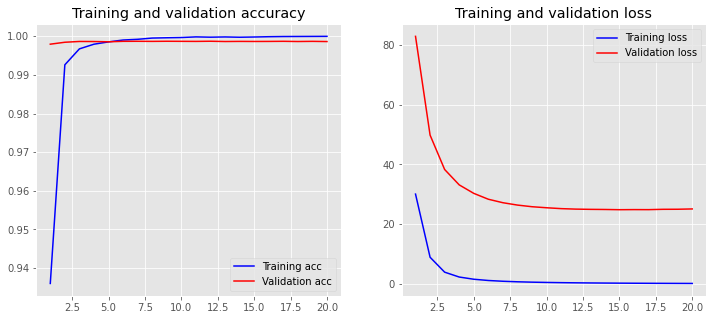

12/12 [==============================] - 5s 173ms/step
F1-score: 86.9%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8802642444260942,0.8582930756843801,0.8691398287810844,1242.0
micro avg,0.8802642444260942,0.8582930756843801,0.8691398287810844,1242.0
macro avg,0.8802642444260942,0.8582930756843801,0.8691398287810844,1242.0
weighted avg,0.8802642444260943,0.8582930756843801,0.8691398287810844,1242.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2119 words (12207 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 545, 100)          1432600   
                                                                 
 bidirectional_3 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,594,012
Trainable params: 1,594,012
Non-trainable 

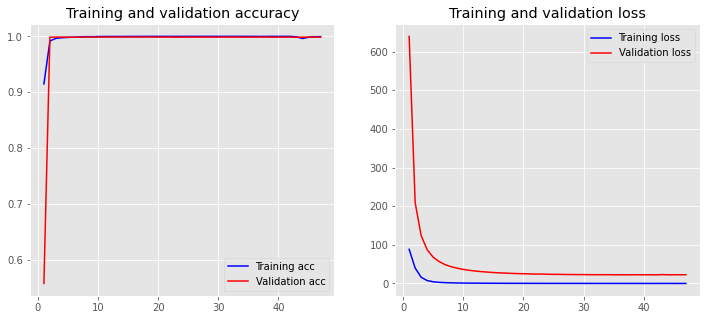

12/12 [==============================] - 5s 172ms/step
F1-score: 87.0%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8753056234718827,0.8647342995169082,0.8699878493317131,1242.0
micro avg,0.8753056234718827,0.8647342995169082,0.8699878493317131,1242.0
macro avg,0.8753056234718827,0.8647342995169082,0.8699878493317131,1242.0
weighted avg,0.8753056234718828,0.8647342995169082,0.8699878493317131,1242.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2122 words (12209 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 545, 100)          1433100   
                                                                 
 bidirectional_4 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,594,512
Trainable params: 1,594,512
Non-trainable 

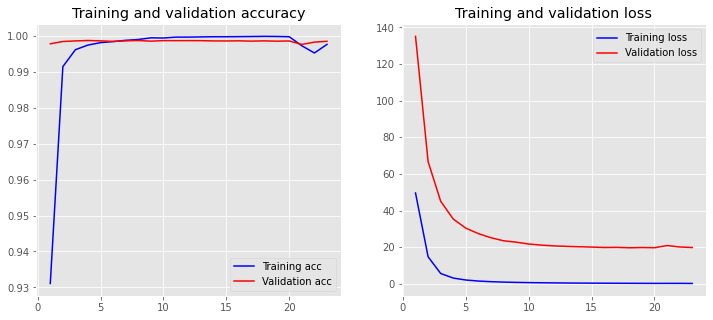

12/12 [==============================] - 5s 179ms/step
F1-score: 87.3%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8889816360601002,0.857487922705314,0.8729508196721312,1242.0
micro avg,0.8889816360601002,0.857487922705314,0.8729508196721312,1242.0
macro avg,0.8889816360601002,0.857487922705314,0.8729508196721312,1242.0
weighted avg,0.8889816360601003,0.857487922705314,0.8729508196721312,1242.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2147 words (12207 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 545, 100)          1435400   
                                                                 
 bidirectional_5 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,596,812
Trainable params: 1,596,812
Non-trainable 

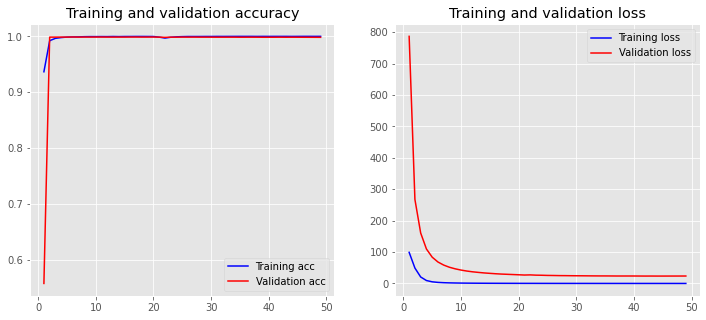

12/12 [==============================] - 5s 174ms/step
F1-score: 88.0%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.9253333333333333,0.8381642512077294,0.8795944233206591,1242.0
micro avg,0.9253333333333333,0.8381642512077294,0.8795944233206591,1242.0
macro avg,0.9253333333333333,0.8381642512077294,0.8795944233206591,1242.0
weighted avg,0.9253333333333332,0.8381642512077294,0.8795944233206592,1242.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2121 words (12197 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 545, 100)          1431800   
                                                                 
 bidirectional_6 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,593,212
Trainable params: 1,593,212
Non-trainable 

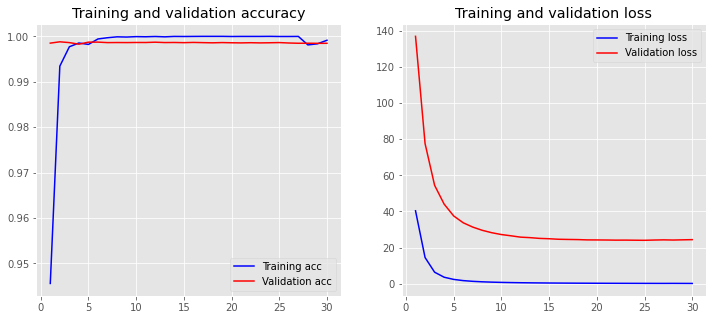

12/12 [==============================] - 5s 177ms/step
F1-score: 87.2%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8895397489539749,0.855877616747182,0.8723840787853918,1242.0
micro avg,0.8895397489539749,0.855877616747182,0.8723840787853918,1242.0
macro avg,0.8895397489539749,0.855877616747182,0.8723840787853918,1242.0
weighted avg,0.8895397489539749,0.855877616747182,0.8723840787853918,1242.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2128 words (12228 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 545, 100)          1435600   
                                                                 
 bidirectional_7 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,597,012
Trainable params: 1,597,012
Non-trainable 

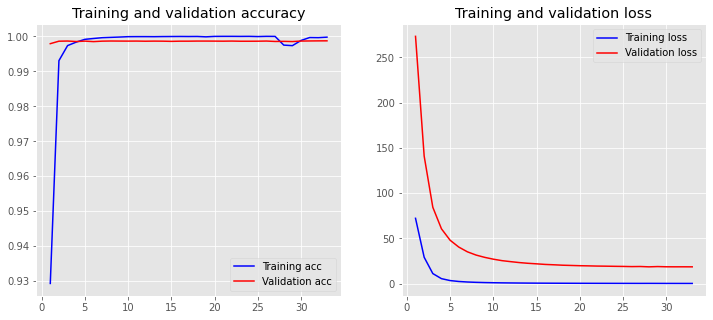

12/12 [==============================] - 5s 179ms/step
F1-score: 86.7%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.870235198702352,0.8639291465378421,0.8670707070707071,1242.0
micro avg,0.870235198702352,0.8639291465378421,0.8670707070707071,1242.0
macro avg,0.870235198702352,0.8639291465378421,0.8670707070707071,1242.0
weighted avg,0.870235198702352,0.8639291465378421,0.8670707070707071,1242.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2108 words (12189 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 545, 100)          1429700   
                                                                 
 bidirectional_8 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,591,112
Trainable params: 1,591,112
Non-trainable 

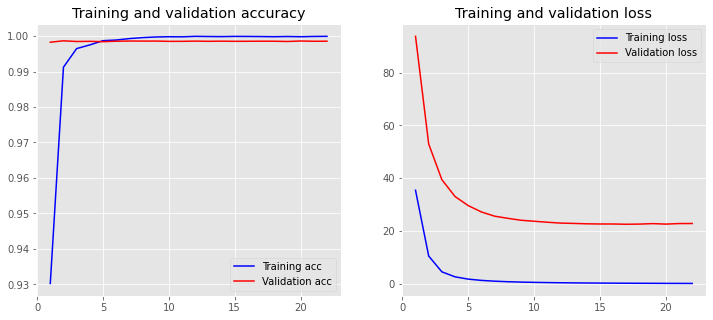

12/12 [==============================] - 5s 174ms/step
F1-score: 86.3%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.8711001642036125,0.8542673107890499,0.8626016260162601,1242.0
micro avg,0.8711001642036125,0.8542673107890499,0.8626016260162601,1242.0
macro avg,0.8711001642036125,0.8542673107890499,0.8626016260162601,1242.0
weighted avg,0.8711001642036126,0.8542673107890499,0.8626016260162601,1242.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 2127 words (12239 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 545, 100)          1436600   
                                                                 
 bidirectional_9 (Bidirectio  (None, 545, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 545, 3)           603       
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 545, 3)            9         
                                                                 
Total params: 1,598,012
Trainable params: 1,598,012
Non-trainable 

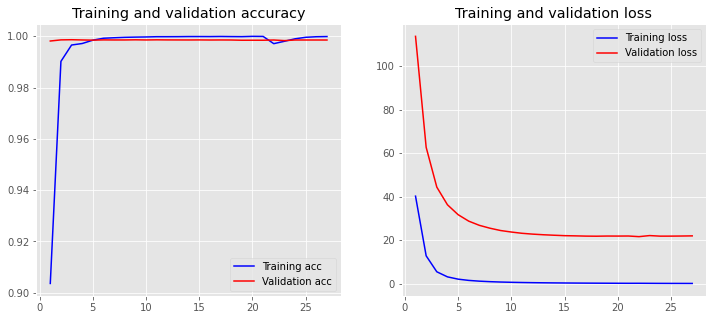

12/12 [==============================] - 5s 174ms/step
F1-score: 85.1%
Classification Report:
,precision,recall,f1-score,support
LEGISLACAO,0.847444089456869,0.8542673107890499,0.8508420208500401,1242.0
micro avg,0.847444089456869,0.8542673107890499,0.8508420208500401,1242.0
macro avg,0.847444089456869,0.8542673107890499,0.8508420208500401,1242.0
weighted avg,0.847444089456869,0.8542673107890499,0.8508420208500401,1242.0



In [13]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)